# Single and Bi-Tensor models

In [1]:
import os
import os.path
import sys
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

module_path = os.path.join(os.path.abspath(os.path.join('..')), 'pymods')
if module_path not in sys.path:
    sys.path.append(module_path)
from plotutils import plot_3d_z_indices

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import nibabel as nib


In [2]:
base_filename = "../data/output/S264294/S264294_DTI_gated_20150508093306_12"

In [3]:
#fdwi = base_filename + "_crop.nii.gz"
fdwi = base_filename + "_syn.nii.gz"
fbval = base_filename + ".bval"
fbvec = base_filename + ".bvec"

In [4]:
img = nib.load(fdwi)
data = img.get_data()

In [5]:
data.shape

(40, 45, 12, 65)

In [6]:
print(img.header.get_zooms()[:3])

(1.9827586, 1.9827586, 2.0)


In [7]:
from dipy.io import read_bvals_bvecs
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)

In [8]:
from dipy.core.gradients import gradient_table
gtab = gradient_table(bvals, bvecs)

In [9]:
gtab.info

B-values shape (65,)
         min 0.000000 
         max 1000.000000 
B-vectors shape (65, 3)
         min -0.964118 
         max 0.999988 


In [10]:
# b values for single shell
print(gtab.bvals)

[   0. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000.]


In [11]:
# First few gradient directions
print(gtab.bvecs[:10, :])

[[ 0.          0.          0.        ]
 [ 0.999975   -0.00504502 -0.00503994]
 [ 0.          0.999988   -0.00497989]
 [-0.0249489   0.65464    -0.755529  ]
 [ 0.589353   -0.769866   -0.244886  ]
 [-0.235876   -0.529835   -0.81464   ]
 [-0.893575   -0.264756   -0.36253   ]
 [ 0.797989    0.133987   -0.58759   ]
 [ 0.232856    0.932211   -0.277056  ]
 [ 0.936737    0.145261   -0.31847   ]]


In [12]:
S0s = data[:, :, :, gtab.b0s_mask]
S0s.shape

(40, 45, 12, 1)

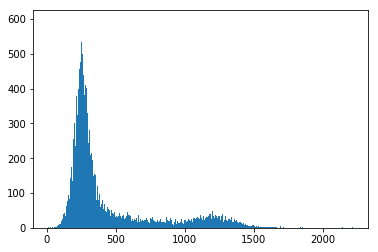

In [13]:
#histogram of the S0 values (b0 image)
x = plt.hist(S0s.ravel(), 500)

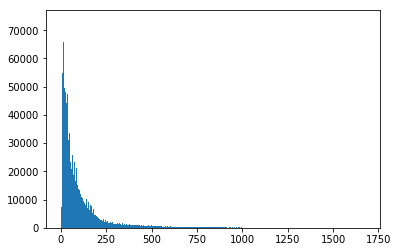

In [14]:
# Histogram of the S_k values
x = plt.hist(data[:, :, :, ~gtab.b0s_mask].ravel(), 500)

The S0 values look nicely bimodal. The S_k values look gaussian with wierd spikes. Are these from eddy currents or head motion?

# Single Compartment model

In [15]:
import dipy.reconst.dti as dti
tenmodel = dti.TensorModel(gtab)
tenfit = tenmodel.fit(data)

## Fractional Anisotropy

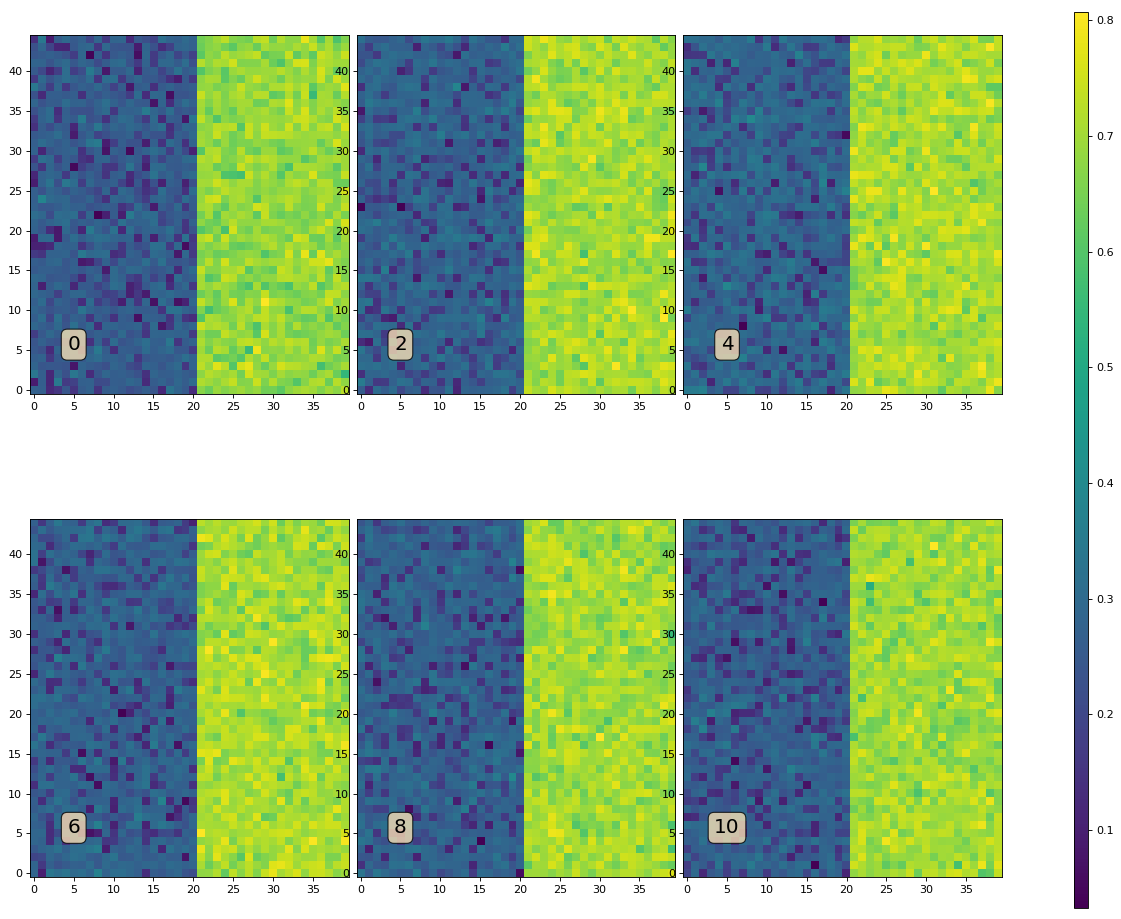

In [16]:
FA = dti.fractional_anisotropy(tenfit.evals)
plot_3d_z_indices(FA, range(0,12, 2), transpose=True, num_rows=2, num_cols=3)

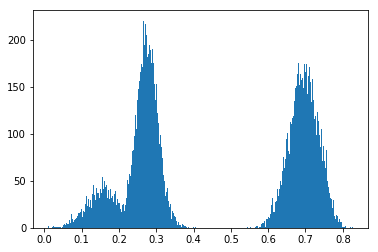

In [17]:
x = plt.hist(FA.ravel(), bins=500)

# Mean Diffusivity

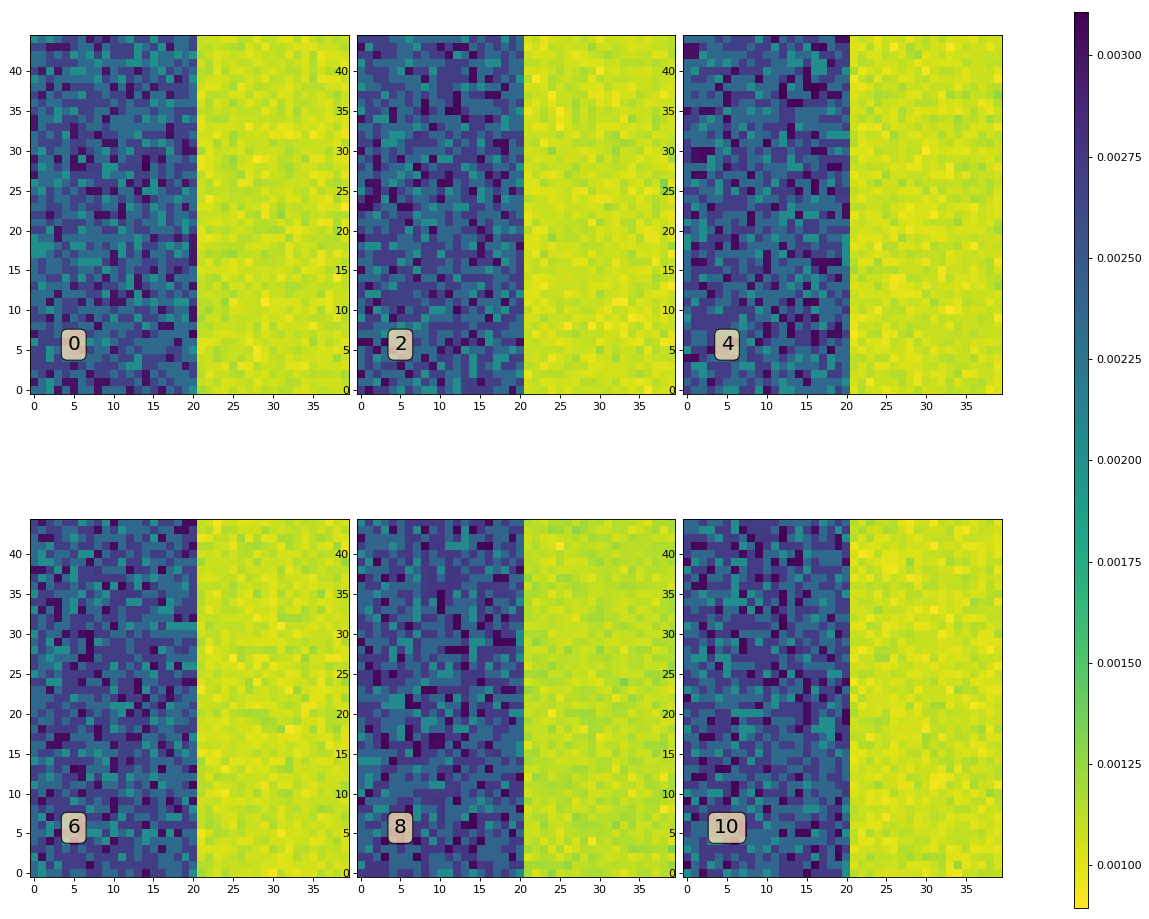

In [18]:
MD1 = dti.mean_diffusivity(tenfit.evals)
plt.set_cmap("viridis_r")
# Plot the MD for a few z-indices
plot_3d_z_indices(MD1, range(0,12, 2), transpose=True, num_rows=2, num_cols=3)

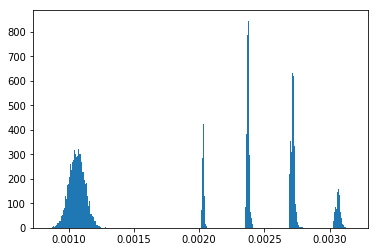

In [19]:
x = plt.hist(MD1.ravel(), bins=500)

# Bi-tensor Model (Free Water)

In [20]:
ADC_water = 3 * 1e-3
b_value = gtab.bvals[1]
Awater_scalar = np.exp(- b_value * ADC_water)
print("Awater_k = %.2f" % Awater_scalar)

Awater_k = 0.05


In [21]:
data_bi = data.astype(np.float_, copy=True)
S0s_bi = data_bi[:,:,:,gtab.b0s_mask]

Make sure there are no zeros in our signal and everything is positive

In [22]:
print("Min = %f, Max=%f" % (data_bi.min(), data_bi.max()))

Min = 0.000000, Max=2216.000000


In [23]:
data_bi[data_bi <= 0] = dti.MIN_POSITIVE_SIGNAL

In [24]:
print("Min = %f, Max=%f" % (data_bi.min(), data_bi.max()))

Min = 0.000100, Max=2216.000000


In [25]:
# Attenuations
Ahat = data_bi.copy() # attenuations
Ahat = Ahat / S0s_bi  

In [26]:
max_diffusivity = 5e-3
attenuation_min = np.exp(- b_value * max_diffusivity )

min_diffusivity = 0.01 * 1e-3
attenuation_max = np.exp(-b_value * min_diffusivity)

print("Attenuation_min = %.3f, Attenuation_max = %.3f" % 
      (attenuation_min, attenuation_max))

Attenuation_min = 0.007, Attenuation_max = 0.990


In [27]:
#Clip the attenuations to attenuation_min and attenuation_max
mask = Ahat < attenuation_min
mask[:,:,:, gtab.b0s_mask] = False
Ahat[Ahat < attenuation_min] = attenuation_min

mask = Ahat > attenuation_max
mask[:,:,:, gtab.b0s_mask] = False
Ahat[Ahat > attenuation_max] = attenuation_max

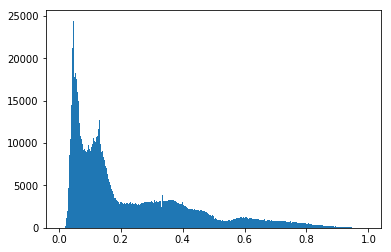

In [28]:
x = plt.hist(Ahat[:,:,:, ~gtab.b0s_mask].ravel(), bins=500)

## Initialization of Free Water Map

Fraction of Data Selected = 0.07


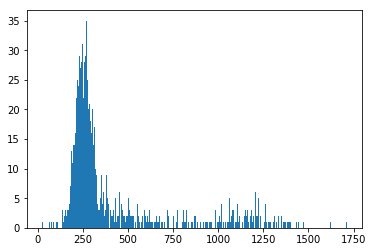

In [29]:
# look at the distribution of voxels in the b0 image that are near 3*1e-3 mm^2/s
mask = np.abs(MD1 - 3 * 1e-3) < 0.2 * 1e-3
print("Fraction of Data Selected = %.2f" % (sum(mask.ravel()) / mask.size))
x = plt.hist(S0s_bi[mask].ravel(), bins=500)

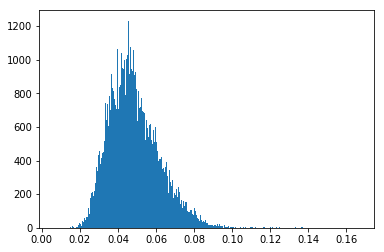

In [30]:
# Lets look at the attentuation when the FA is close to that of water
x = plt.hist(Ahat[:,:,:,1:65][mask].ravel(), bins=500)

In [31]:
#Lets set the value of Swater to be 1500 as that is close 
# to the end of the distribution in percentile terms
Swater = 1500 

Fraction of Data Selected = 0.07


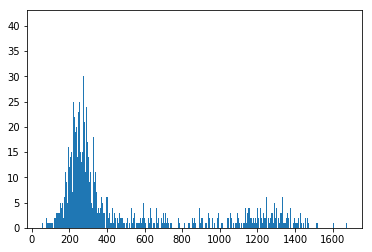

In [32]:
# look at the distribution of voxels that are near 0.8*1e-3 mm^2/s
mask = np.abs(MD1 - 0.8 * 1e-3) < 0.2 * 1e-3
print("Fraction of Data Selected = %.2f" % (sum(mask.ravel()) / mask.size))
x = plt.hist(S0s_bi[mask].ravel(), bins=500)

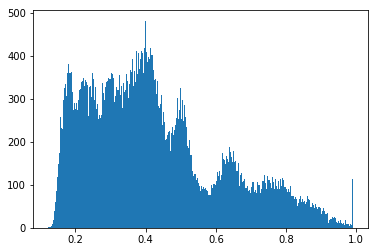

In [33]:
# Lets look at the attentuation when the FA is close to that of 
# white matter 
x = plt.hist(Ahat[:,:,:,1:65][mask].ravel(), bins=500)

In [34]:
# Lets set the value of Stissue to be 200 as that is close
# to the start of the distribution above in percentile terms
Stissue = 200

In [35]:
#Initial free water map

#looking at the distribution of mean diffusivities we can set
lambda_max = 1 * 1e-3 # max diffusivity in tissue
lambda_min = 0.3 * 1e-3 # min diffusivity in tissue

# Max and min attenuation. (Amax uses lambda_min and vice versa)
Amax = np.exp(-b_value * lambda_min)
Amin = np.exp(-b_value * lambda_max)

print("Amin=%.2f, Amax = %.2f" % (Amin, Amax))

Ahat_min = Ahat[..., ~gtab.b0s_mask].min(axis=3)
Ahat_max = Ahat[...,~gtab.b0s_mask].max(axis=3)

print("Ahat_min.shape = %s" % str(Ahat_min.shape))
print("Ahat_max.shape = %s" % str(Ahat_max.shape))

# Note this formula is perhaps a correction of Equation [6]
fmin = (Ahat_min - Awater_scalar) / (Amax - Awater_scalar)
fmax = (Ahat_max - Awater_scalar) / (Amin - Awater_scalar)

print("fmin.shape = %s" % str(fmin.shape))
print("fmax.shape = %s" % str(fmax.shape))

idx = (20, 25, 6)
print("Ahat_min=%.2f, Ahat_max=%.2f, fmax=%.2f, fmin=%.2f" % 
      (Ahat_min[idx], Ahat_max[idx], fmax[idx], fmin[idx]))

# now make sure fmax and fmin are between 0 and 1

print("fmin.max = %.2f, fmin.min=%.2f" % (fmin.max(), fmin.min()))
fmin[fmin <= 0] = 0.01
fmin[fmin >= 1] = 0.99

print("fmax.max = %.2f, fmax.min=%.2f" % (fmax.max(), fmax.min()))
fmax[fmax <= 0] = 0.01
fmax[fmax >= 1] = 0.99
print("fmax.max = %.2f, fmax.min=%.2f" % (fmax.max(), fmax.min()))

print("Ahat_min=%.2f, Ahat_max=%.2f, fmax=%.2f, fmin=%.2f" % 
      (Ahat_min[idx], Ahat_max[idx], fmax[idx], fmin[idx]))

# FIXME: setting fmin to 0 and fmax to 1
fmin[...] = 0 + 0.00001
fmax[...] = 1 - 0.00001

f_init = 1 - (np.log(np.squeeze(S0s_bi) / Stissue) / np.log(Swater / Stissue))
print("f_init.shape = %s" % str(f_init.shape))
mask = f_init < fmin
f_init[mask] = (fmin[mask] + fmax[mask])/2
mask = f_init > fmax
f_init[mask] = (fmin[mask] + fmax[mask])/2

f_init = f_init[:,:,:,np.newaxis]

# This is our starting value of f
print("f_init.shape = %s" % str(f_init.shape))
print("f_init.max = %.2f, f_init.min=%.2f" % (f_init.max(), f_init.min()))

Amin=0.37, Amax = 0.74
Ahat_min.shape = (40, 45, 12)
Ahat_max.shape = (40, 45, 12)
fmin.shape = (40, 45, 12)
fmax.shape = (40, 45, 12)
Ahat_min=0.04, Ahat_max=0.14, fmax=0.29, fmin=-0.01
fmin.max = 0.24, fmin.min=-0.06
fmax.max = 2.96, fmax.min=-0.00
fmax.max = 0.99, fmax.min=0.00
Ahat_min=0.04, Ahat_max=0.14, fmax=0.29, fmin=0.01
f_init.shape = (40, 45, 12)
f_init.shape = (40, 45, 12, 1)
f_init.max = 1.00, f_init.min=0.00


In [36]:

print("f_init.max = %.2f" % f_init.max())
print("Ahat.max = %.2f" % Ahat.max())

Cwater = (1 - f_init) * Awater_scalar
print("b_value = %.2f" % b_value)
print("Cwater.max = %.2f" % Cwater.max())
print(Cwater.shape)

Ahat_tissue = (Ahat - Cwater) / f_init
print(Ahat_tissue.shape)

#np.unravel_index(Ahat_tissue.argmax(), Ahat_tissue.shape)
#print(Ahat.max())
#print(Ahat_tissue.max())
#print(Ahat_tissue.argmin())

#idx = np.unravel_index(Ahat_tissue.argmin(), Ahat_tissue.shape)
#print(idx)


f_init.max = 1.00
Ahat.max = 0.99
b_value = 1000.00
Cwater.max = 0.05
(40, 45, 12, 1)
(40, 45, 12, 65)


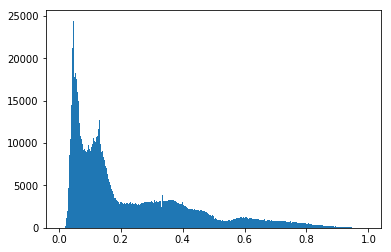

In [37]:
x = plt.hist(Ahat[:,:,:,~gtab.b0s_mask].ravel(), 500)

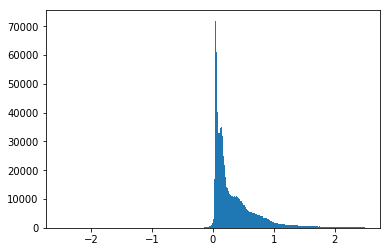

In [38]:
attenuations = Ahat_tissue[:,:,:,~gtab.b0s_mask]
np.clip(attenuations, a_min=-2.5, a_max=2.5, out=attenuations)
x = plt.hist(attenuations.ravel(), 500)

In [39]:
# This is our starting value of D
tenfit.quadratic_form.shape

(40, 45, 12, 3, 3)

In [40]:
tenfit.quadratic_form[20, 20, :, 2, 2]

array([0.00203525, 0.00304131, 0.00203375, 0.0030398 , 0.00303044,
       0.00203437, 0.00302904, 0.002024  , 0.00202509, 0.00303744,
       0.00308746, 0.00204414])

In [41]:
from tracer import Tracer, LossTracer, IdxTracer

In [42]:
from freewater import FreeWaterGradientDescent, create_feature_spatial_manifold

In [43]:
class SmallIdxTracer(Tracer):
    """Trace values at one index"""
        
    def __init__(self, idx, 
            val_names="loss_fid,x4inc,x4m"):
        Tracer.__init__(self, val_names)
        self.idx = idx

    def extract_value_from_array(self, fw, arr_name):
        return(np.asscalar(getattr(fw, arr_name)[self.idx]))

    def trace_after_loss_functions(self, fw):
        arr_names = self.val_names[:-1] # remove x4m
        #x4m is extracted differently
        x4m = np.asscalar(fw.manifold[...,0][self.idx])
        self.add_to_list(
            [self.extract_value_from_array(fw, name) for name in arr_names] + 
            [x4m])

In [44]:
manifold = create_feature_spatial_manifold(S0s, tenfit.quadratic_form)
num_gradients = np.sum(~gtab.b0s_mask)
dt = 0.001 / (b_value * num_gradients)
dt *= 300000

f_init_copy = f_init.copy()
f_init_copy[...] = 1.
fw_gd = FreeWaterGradientDescent(Ahat, manifold, f_init_copy, gtab, b_value, dt)

fw_gd.beta=10.

idx_tracer = SmallIdxTracer((14, 30, 11, Ellipsis))
loss_tracer = LossTracer()
fw_gd.init_tracers([loss_tracer, idx_tracer])

idx = idx_tracer.idx

fw_gd.alpha_fid = 0.
fw_gd.alpha_reg = 1.
fw_gd.alpha_f = 0.


if 1:
    num_iterations = 200
    for i in range(num_iterations):
        fw_gd.iterate()

    fw_gd.finalize()

    idx_array = idx_tracer.rec
    loss_array = loss_tracer.rec


In [45]:
fw_gd.fid4inc[idx]

array(-86.00381515)

In [46]:
fw_gd.dt

0.0046875

In [47]:
# Plot tissue map, loss functions for idx
#idx_tracer.plot_separate()

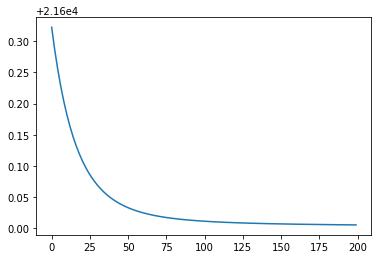

In [48]:
plt.plot(loss_tracer.rec.loss)

In [49]:
def convert_manifold_to_lower_tri_order(manifold):
    """The lower tri ordering is  Dxx, Dxy, Dyy, Dxz,Dyz, Dzz.
       The manifold ordering is Dxx, Dyy, Dzz, sqrt(2)*Dxy, sqrt(2)*Dyz, sqrt(2)*Dzz 
    """
    ret = manifold[..., np.array([0,3,1,5,4,2])]
    ret[...,1] /= np.sqrt(2) # Dxy
    ret[...,3] /= np.sqrt(2) # Dxz
    ret[...,4] /= np.sqrt(2) # Dyz
    return(ret)

In [50]:
lower_tri = convert_manifold_to_lower_tri_order(fw_gd.manifold)

In [51]:
from dipy.reconst.dti import decompose_tensor, from_lower_triangular
evals, evecs = decompose_tensor(from_lower_triangular(lower_tri), min_diffusivity=0.)

In [52]:
MD = evals.mean(axis=-1)

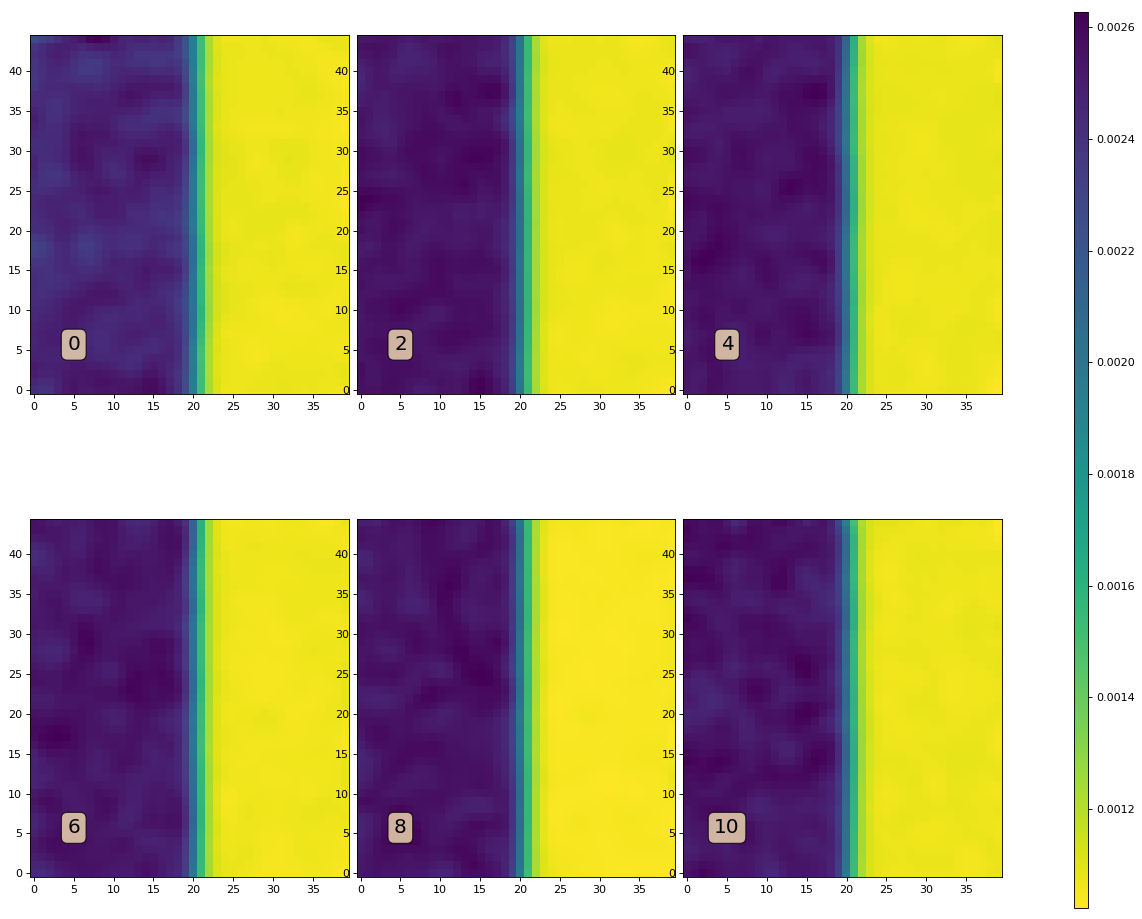

In [53]:
plot_3d_z_indices(MD, idx_list=range(0, 12, 2), num_cols=3, num_rows=2)

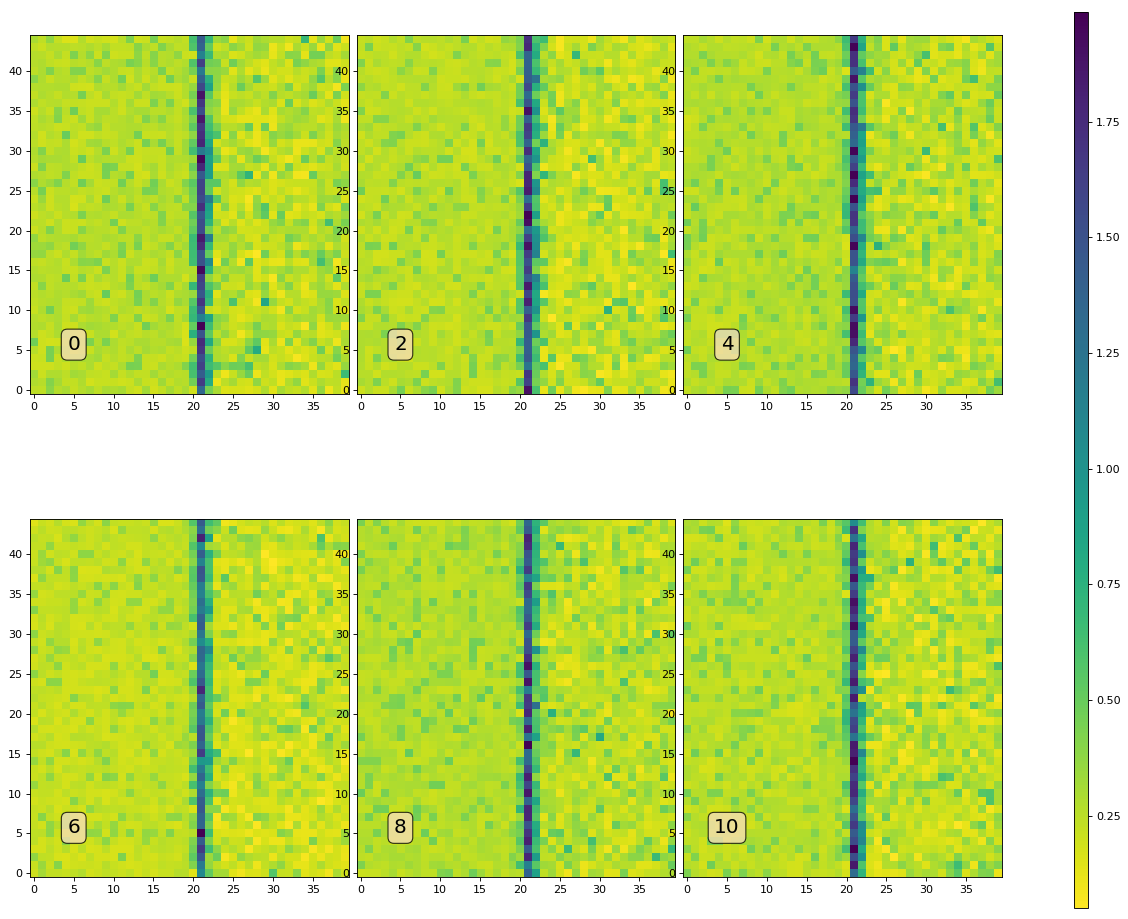

In [54]:
plot_3d_z_indices(fw_gd.loss_fid, idx_list=range(0, 12, 2), num_cols=3, num_rows=2)

In [55]:
idx = idx_tracer.idx
print("Index:", idx)
nearby_slice = (slice(idx[0]-1, idx[0] + 2), slice(idx[1] - 1, idx[1] + 2), 
                slice(idx[2]-1, idx[2] + 2), Ellipsis)

def insp(arrname):
    "Inspect fw_gd at idx"
    ret = getattr(fw_gd, arrname)[idx]
    if ret.size == 1:
        ret = np.asscalar(ret)
    return(ret)

if 0:
    #fw_gd.iterate()
    print("Manifold[0] at index", fw_gd.manifold[...,0][idx])
    print("x index below idx:", manifold[...,0][(idx[0] - 1,) +  idx[1:]])
    print("y index below idx:", manifold[...,0][(idx[0], idx[1] - 1,) +  idx[2:]])
    print("z index below idx:", manifold[...,0][(idx[0], idx[1], idx[2] - 1,) +  idx[3:]])
    print()
    print("X4x at Index:", insp("X4x"))
    print("X4y at Index:", insp("X4y"))
    print("X4z at Index:", insp("X4z"))
    print(fw_gd.manifold[...,0][nearby_slice])

    print()
    print("Manifold[3] at index", fw_gd.manifold[...,3][idx])
    print("x index below idx:", manifold[...,3][(idx[0] - 1,) +  idx[1:]])
    print("y index below idx:", manifold[...,3][(idx[0], idx[1] - 1,) +  idx[2:]])
    print("z index below idx:", manifold[...,3][(idx[0], idx[1], idx[2] - 1,) +  idx[3:]])
    print()
    print("X7x at Index:", insp("X7x"))
    print("X7y at Index:", insp("X7y"))
    print("X7z at Index:", insp("X7z"))
    print(fw_gd.manifold[...,3][nearby_slice])

Index: (14, 30, 11, Ellipsis)


In [56]:
if 0:
    for i in range(4, 10):
        arrname = "X" + str(i) + "x"
        print(arrname + "=", insp(arrname))

    res = 1 + 10 * (insp("X4x") * insp("X4x")+ \
        insp("X5x") * insp("X5x") + \
        insp("X6x") * insp("X6x") + \
        insp("X7x") * insp("X7x") + \
        insp("X8x") * insp("X8x") + \
        insp("X9x") * insp("X9x"))
    print("\nres=", res)
    print("g11=", insp("g11"))

    print("\nC11=", insp("C11"))
    print("C22=", insp("C22"))
    print("C33=", insp("C33"))
    print("C12=", insp("C12"))
    print("C13=", insp("C13"))
    print("C23=", insp("C23"))

    print("\nInsp detg=", insp("detg"))
    arr = np.array([[insp("g11"), insp("g12"), insp("g13")],
              [insp("g12"), insp("g22"), insp("g23")],
              [insp("g13"), insp("g23"), insp("g33")]])
    print("Calc detg=", np.linalg.det(arr))
    # different ways of calculating detg should also validate that the C's are correct
    det_row2 = insp("g11") * insp("C11") + insp("g12") * insp("C12") + insp("g13")*insp("C13")
    det_row3 = insp("g12") * insp("C12") + insp("g22") * insp("C22") + insp("g23")*insp("C23")
    print("det row2 =", det_row2)
    print("det row3 =", det_row3)
    print("Gm05 = ", insp("gm05"))

    print("\np4 = ", insp("p4"))
    print("p7 = ", insp("p7"))
    print("q4 = ", insp("q4"))
    print("q7 = ", insp("q7"))
    print("r4 = ", insp("r4"))
    print("r7 = ", insp("r7"))

    print("\nb4inc = ", insp("b4inc"))
    print("b7inc = ", insp("b7inc"))


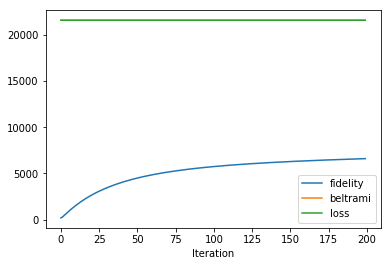

In [57]:
#loss functions
if 0:
    loss_array.loss[0:2] = np.NaN
    loss_array.fidelity[0:2] = np.NaN
    loss_array.beltrami[0:2] = np.NaN

loss_tracer.plot_overlaid()

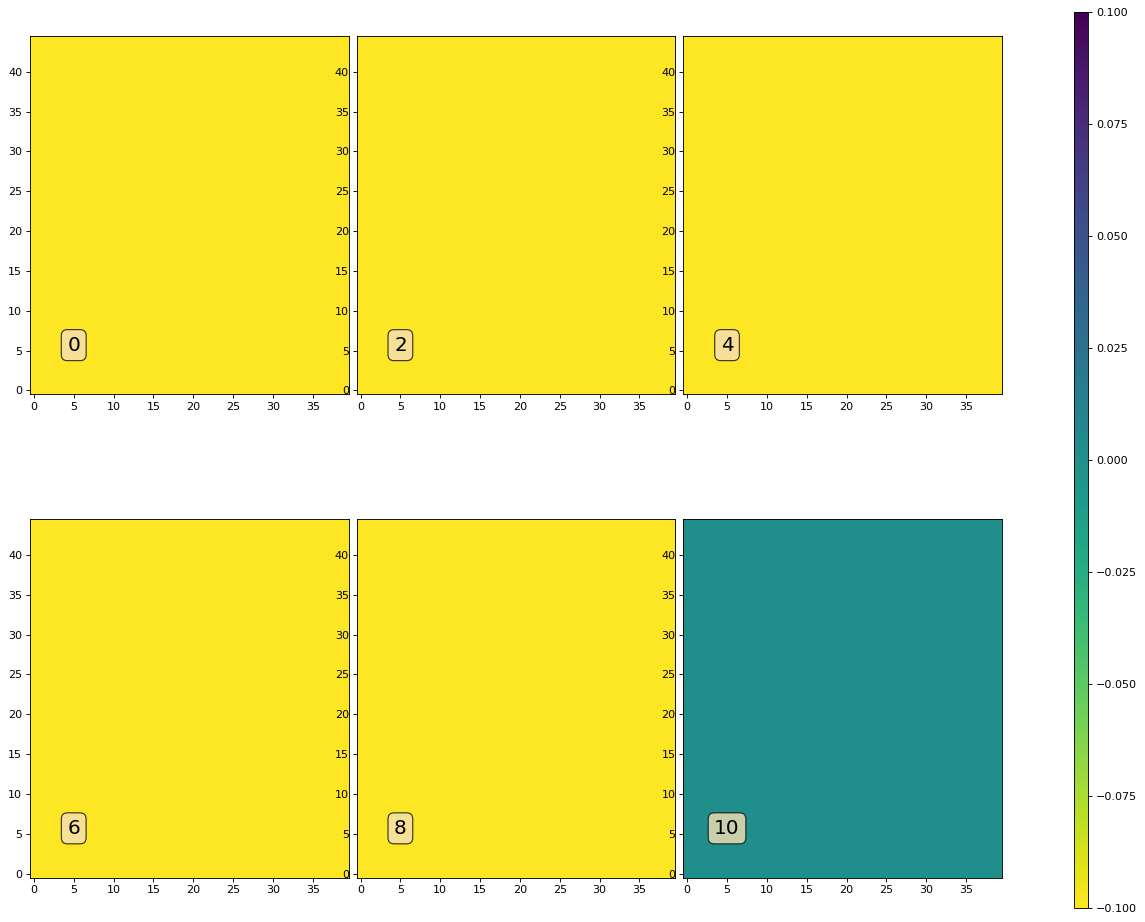

In [58]:
# free water map after iterations
plt.set_cmap("viridis_r")
plot_3d_z_indices(1 - fw_gd.f.squeeze(), range(0,12, 2), transpose=True, num_rows=2, num_cols=3)

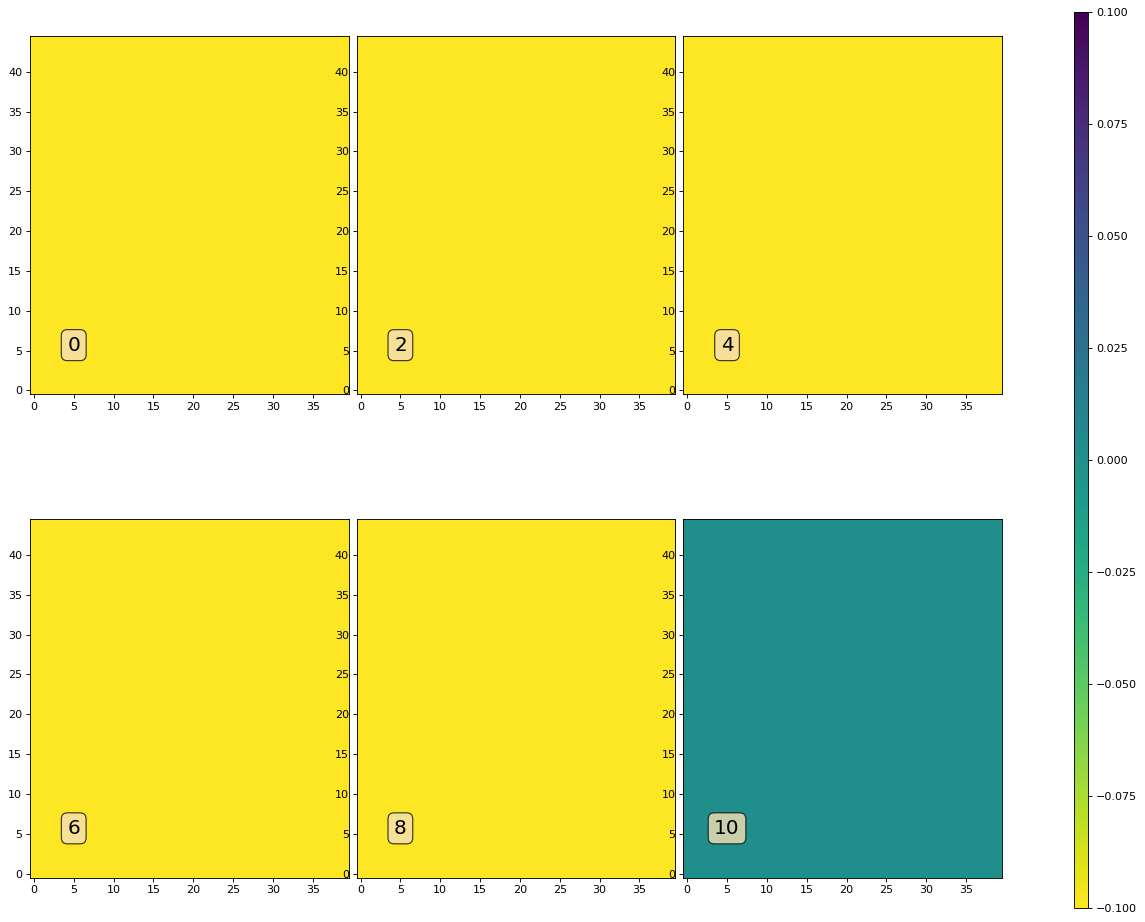

In [59]:
# initial Free water map
plt.set_cmap("viridis_r")
plot_3d_z_indices(1 - fw_gd.f_init.squeeze(), range(0,12, 2), transpose=True, num_rows=2, num_cols=3)

In [60]:
# save free water output to file
fw_file = base_filename + ".fw.nii.gz"
nib.save(nib.Nifti1Image((1 - fw_gd.f).squeeze(), img.affine), fw_file)